In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from typing import List, Tuple
from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import OrderedDict
import copy

In [2]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor) -> None:
    """Plots decision boundaries of a given PyTorch model, in comparison to the ground truth.

    Args:
        model (torch.nn.Module): The PyTorch model to visualize.
        X (torch.Tensor): The input tensor for the model.
        y (torch.Tensor): The ground truth tensor.

    Returns:
        None.

    """
    # Transfer the model and data to CPU
    device = torch.device("cpu")
    model.to(device)
    X, y = X.to(device), y.to(device)

    # Create a grid of prediction boundaries
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Convert the grid to a PyTorch tensor
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float().to(device)

    # Make predictions using the model
    model.eval()
    with torch.no_grad():
        y_logits = model(X_to_pred_on)

    # Determine if this is a binary or multi-class classification problem
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # multi-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape the prediction tensor and plot the decision boundary
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)

    # Plot the original data points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

# Small Recap

In [3]:


# Check PyTorch version
torch.__version__

'2.2.2'

In [4]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


# Perceptron from Lab 4

In [5]:
x = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
y = torch.tensor([[0], [0], [0], [1]], dtype=torch.float32)
if x.shape[0] == y.shape[0]:
    print("The shapes of our data match !")


The shapes of our data match !


Firstly, the code defines a subclass of nn.Module, which is a superclass that almost all PyTorch models inherit from.

The class constructor creates two nn.Linear layers with the capacity to handle the input and output shapes of the input features X and target labels y.

Next, the forward() method is defined, which contains the computations for the forward pass of the model.

Finally, an instance of the model class is created and sent to the designated device for computation.

In [6]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Perceptron, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim) # takes in {input_dim}  features (X), produces {output_dim} features
        self.activation = torch.nn.Sigmoid()
        
    def forward(self, x):
        # x = self.linear(x)
        # x = self.activation(x)
        ## The upper line and lower are equivalent
        x =self.activation(self.linear(x)) #Takes in the computation through the linear layer and the resulting features of the linear layer through the activation
        return x
# Example usage:
model = Perceptron(2, 1)

Choosing an optimizer

In [7]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)


Training loop:

In [8]:
num_epochs = 4000
loss_values = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    # Print the loss every 100 epochs
    loss_values.append(loss.item()) # This is so that we can look at an image of our loss
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/4000], Loss: 0.3372
Epoch [200/4000], Loss: 0.2467
Epoch [300/4000], Loss: 0.1961
Epoch [400/4000], Loss: 0.1630
Epoch [500/4000], Loss: 0.1395
Epoch [600/4000], Loss: 0.1217
Epoch [700/4000], Loss: 0.1079
Epoch [800/4000], Loss: 0.0969
Epoch [900/4000], Loss: 0.0878
Epoch [1000/4000], Loss: 0.0803
Epoch [1100/4000], Loss: 0.0739
Epoch [1200/4000], Loss: 0.0684
Epoch [1300/4000], Loss: 0.0637
Epoch [1400/4000], Loss: 0.0595
Epoch [1500/4000], Loss: 0.0559
Epoch [1600/4000], Loss: 0.0526
Epoch [1700/4000], Loss: 0.0497
Epoch [1800/4000], Loss: 0.0471
Epoch [1900/4000], Loss: 0.0448
Epoch [2000/4000], Loss: 0.0427
Epoch [2100/4000], Loss: 0.0407
Epoch [2200/4000], Loss: 0.0389
Epoch [2300/4000], Loss: 0.0373
Epoch [2400/4000], Loss: 0.0358
Epoch [2500/4000], Loss: 0.0344
Epoch [2600/4000], Loss: 0.0331
Epoch [2700/4000], Loss: 0.0319
Epoch [2800/4000], Loss: 0.0308
Epoch [2900/4000], Loss: 0.0298
Epoch [3000/4000], Loss: 0.0288
Epoch [3100/4000], Loss: 0.0279
Epoch [3200/4000]

In [9]:

def plot_loss(loss_values: List[float]):
    plt.plot(loss_values)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.show()

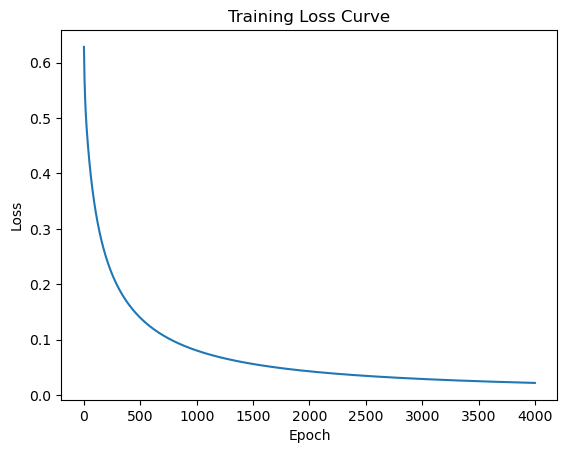

In [10]:
plot_loss(loss_values)

Testing

In [11]:
test_input = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
test_output = model(test_input)
print(test_output)

tensor([[2.4253e-05],
        [2.5133e-02],
        [2.5133e-02],
        [9.6479e-01]], grad_fn=<SigmoidBackward0>)


In [12]:
output = (test_output > 0.5).float()
print(output)

tensor([[0.],
        [0.],
        [0.],
        [1.]])


# Persisting a model

In [13]:
# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)


# 2. Create model save path 
MODEL_NAME = "01_pytorch_perceptron.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models\01_pytorch_perceptron.pth


In [14]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

# Creating a circular dataset

In [15]:
# Make 2000 samples 
sample_size = 2000

# Create circles
X, y = make_circles(sample_size,
                    noise=0.05, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [16]:
X

array([[ 0.44520512, -0.55836925],
       [-0.6263146 ,  0.81511963],
       [-0.40089411,  0.7175086 ],
       ...,
       [ 0.62216455, -0.71816765],
       [-0.79036339,  0.13676334],
       [ 0.59930256,  0.55898471]])

In [17]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [18]:
print(f"Last 5 X features:\n{X[-5:]}") #Wink wink numpy slicing
print(f"Last 5 y labels:\n{y[-5:]}")
print(len(X),"  ",len(X[-5:]))

Last 5 X features:
tensor([[ 0.5831,  0.5841],
        [-0.2253,  0.7484],
        [ 0.6222, -0.7182],
        [-0.7904,  0.1368],
        [ 0.5993,  0.5590]])
Last 5 y labels:
tensor([1., 1., 0., 1., 1.])
2000    5


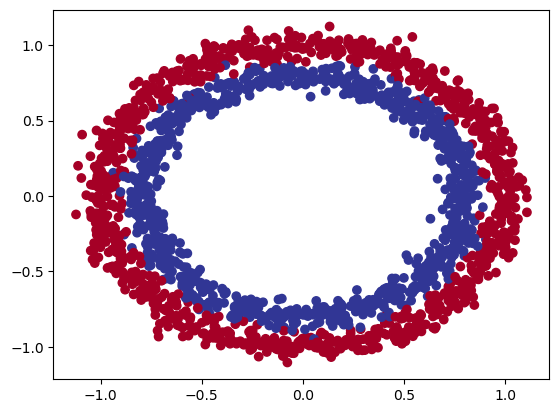

In [19]:
# Visualize with a plot
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

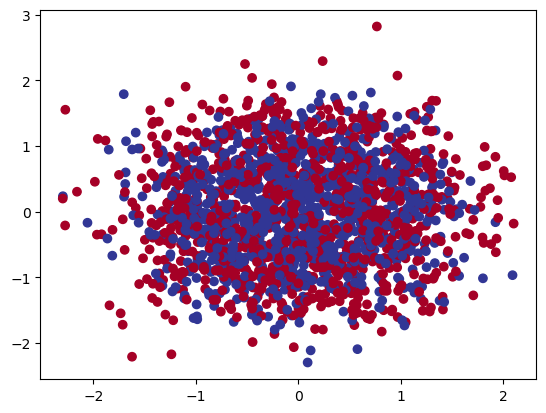

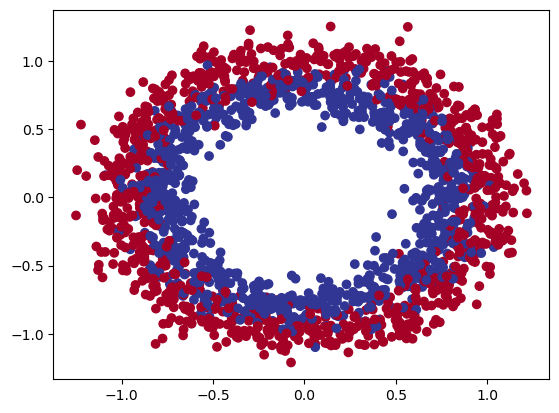

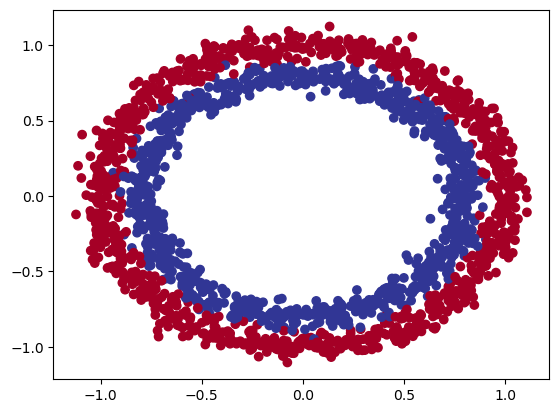

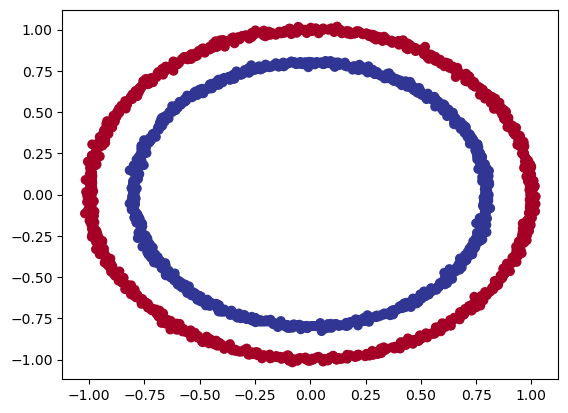

In [20]:
for noise in [0.5, 0.1, 0.05, 0.01]:
    X, y = make_circles(sample_size,
                    noise=noise, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values
    X = torch.from_numpy(X).type(torch.float)
    y = torch.from_numpy(y).type(torch.float)
    plt.scatter(x=X[:, 0], 
                y=X[:, 1], 
                c=y, 
                cmap=plt.cm.RdYlBu);
    plt.show()

# Ex 1

Analyse the data: print the shape of our toy dataset

What's the second dimension on X?

Print some values of the toy dataset

In [21]:
X, y = make_circles(sample_size,
                    noise=0.05, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values
print(X.shape)

(2000, 2)


In [22]:
for index in [1, 17, 259, 1072, 1937]:
    print(X[index], " -> ", y[index])

[-0.6263146   0.81511963]  ->  0
[0.74355381 0.57549626]  ->  0
[-0.05384583  0.83110485]  ->  1
[-0.92851366 -0.21533651]  ->  0
[ 0.56518992 -0.85460932]  ->  0


# Ex 2 :

In the next step, we need to prepare the data to be compatible with PyTorch and for modelling. To achieve this, we have two tasks to complete:

Convert our data from NumPy arrays to PyTorch tensors as PyTorch works more efficiently with tensors. Create a split between the training and testing sets. The model is trained on the training set to learn the relationships between X and y. Afterward, the model's learned patterns are evaluated on the test dataset.

In [23]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

# Ex 3 :

Build a model similar to the perceptron with 2 linear layers (no activation function) Please be mindfull of your model names (distinct names) If capable move your model to the gpu

In [24]:
class DumbModel(nn.Module):
    def __init__(self, optimizer_constructor, loss_fn):
        super(DumbModel, self).__init__()
        self.function = nn.Sequential(
            copy.deepcopy(OrderedDict([('f1', nn.Linear(2, 4)),
                         ('f2', nn.Linear(4, 1))])))
        self.optimizer = optimizer_constructor(self.parameters(), lr=0.1)
        self.loss_fn = loss_fn
        
    def forward(self, X: torch.tensor) -> torch.tensor:
        return self.function(X)
    
    def run(self, inputs: torch.tensor, labels:torch.tensor, epoch_count: int=1_000) -> Tuple[List[float], List[float]]:
        loss_values = []
        acc_values = []
        for epoch in range(epoch_count):
            self.optimizer.zero_grad()
            
            outputs = self(inputs.float())[:,0]
            target = labels.float()
                
            loss = self.loss_fn(outputs, target)
            loss.backward()

            predicted_labels = (outputs >= 0.5).int()
            correct = (predicted_labels == labels.int()).float().sum().item()
            total = labels.size(0)
            accuracy = correct / total
            
            loss_values.append(loss.item())
            acc_values.append(accuracy)
            self.optimizer.step()
            if (epoch + 1) % (epoch_count / 10) == 0:
                print(f"Epoch {epoch + 1:6d}: Loss = {loss.item():.4f}, Accuracy = {100* accuracy:.4f}%")        
        return loss_values, acc_values


2.1 Setup loss function and optimizer
For a binary classification problem you'll often use binary cross entropy as the loss function.

However, the same optimizer function can often be used across different problem spaces.

For example, the stochastic gradient descent optimizer (SGD, torch.optim.SGD()) can be used for a range of problems, so can too the Adam optimizer (torch.optim.Adam()).


Since we're working with a binary classification problem, let's use a binary cross entropy loss function.

Note: Recall a loss function is what measures how wrong your model predictions are, the higher the loss, the worse your model.
Therefore, torch.nn.BCEWithLogitsLoss() is recommended for binary classification tasks. However, for more advanced usage, one may choose to separate the nn.Sigmoid and torch.nn.BCELoss() components, though that is beyond the scope of this notebook. We will now create a loss function and an optimizer.


For the optimizer we'll use torch.optim.SGD() to optimize the model parameters with learning rate 0.1

# Ex 4 :

Create the recommended loss_fn and optimizer

In [25]:
dumb_instance = DumbModel(torch.optim.SGD, torch.nn.BCEWithLogitsLoss())

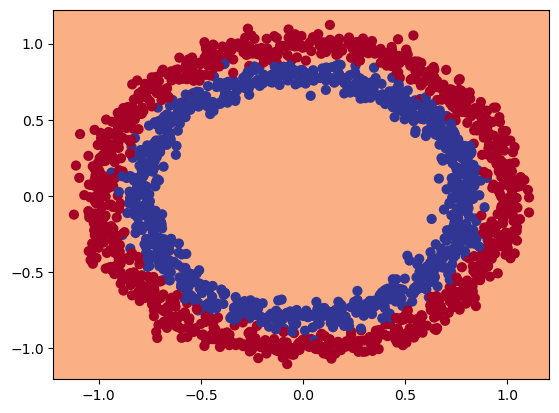

In [26]:
plot_decision_boundary(dumb_instance, X, y)

# Training Loop
PyTorch training loop steps  
    1. Forward pass - The model goes through all of the training data once, performing its forward() function calculations (model(x_train)).  
    2. Calculate the loss - The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are (loss = loss_fn(y_pred, y_train).  
    3. Zero gradients - The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step (optimizer.zero_grad()).  
    4. Perform backpropagation on the loss - Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with requires_grad=True). This is known as backpropagation, hence "backwards" (loss.backward()).  
    5. Step the optimizer (gradient descent) - Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them (optimizer.step()).  

Epoch     50: Loss = 0.6942, Accuracy = 50.1875%
Epoch    100: Loss = 0.6935, Accuracy = 50.1875%
Epoch    150: Loss = 0.6933, Accuracy = 50.1875%
Epoch    200: Loss = 0.6932, Accuracy = 50.1875%
Epoch    250: Loss = 0.6932, Accuracy = 50.1875%
Epoch    300: Loss = 0.6931, Accuracy = 50.1875%
Epoch    350: Loss = 0.6931, Accuracy = 50.1875%
Epoch    400: Loss = 0.6931, Accuracy = 50.1875%
Epoch    450: Loss = 0.6931, Accuracy = 50.1875%
Epoch    500: Loss = 0.6931, Accuracy = 50.1875%


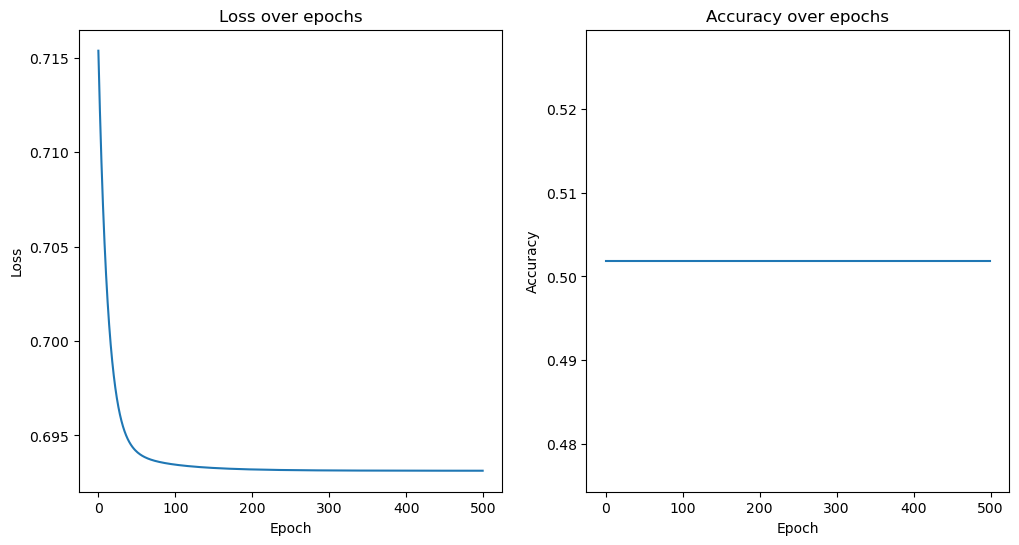

Min loss for 500 epochs is 0.6931328773498535
Min loss for 500 epochs is 0.501875


In [27]:

losses, accuracies = dumb_instance.run(X_train, y_train, epoch_count=500)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.plot(losses)

plt.subplot(1, 2, 2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.plot(accuracies)
    
plt.show()
    
print(f"Min loss for 500 epochs is {losses[-1]}")
print(f"Min loss for 500 epochs is {accuracies[-1]}")

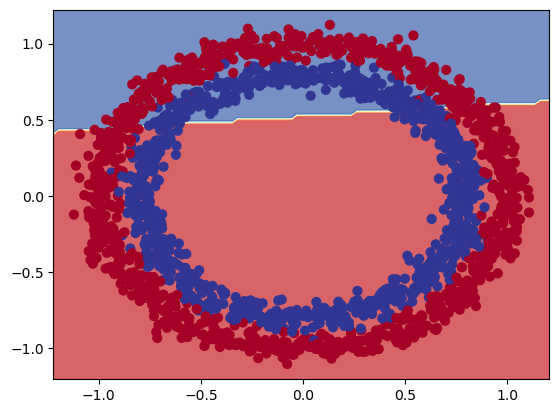

In [28]:
plot_decision_boundary(dumb_instance, X, y)

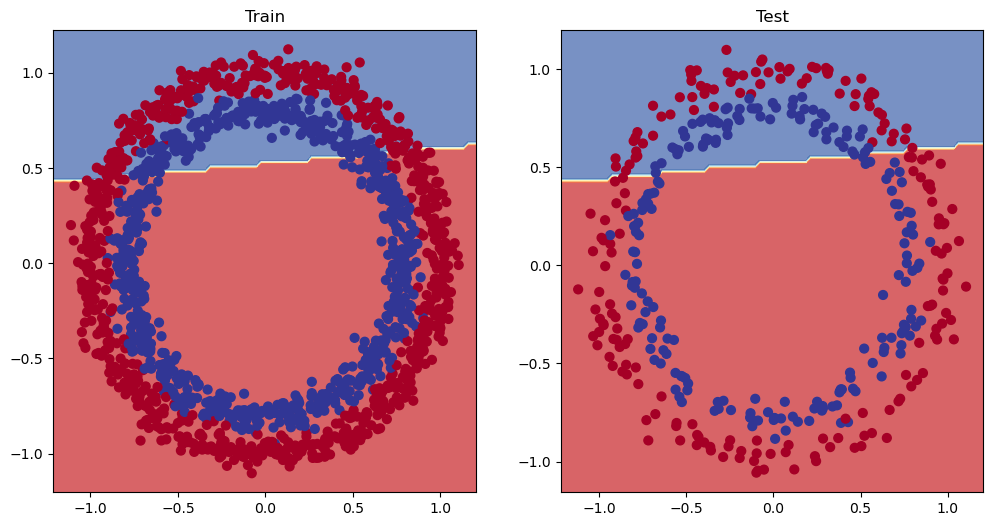

In [29]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(dumb_instance, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(dumb_instance, X_test, y_test)

It can be observed that the model's capability is limited to splitting the data into two parts, which is due to its linearity. This fact accounts for the 50% accuracy rate, as our circular data can only be cut in half by a straight line at best.

In machine learning terminology, we say that our model is underfitting, indicating that it is unable to learn the predictive patterns from the data.

What are some ways to enhance the model's performance?

# Improving a model

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])


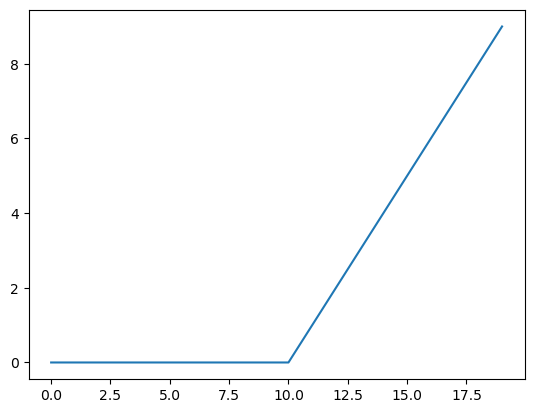

In [30]:
input_dummy = torch.arange(-10, 10, 1, dtype=torch.float32)
print(input_dummy)
def relu(x):
  return torch.maximum(torch.tensor(0), x) # inputs must be tensors

# Pass toy tensor through ReLU function
relu(input_dummy)

plt.plot(relu(input_dummy))

In [31]:
class SmarterModel(nn.Module):
    def __init__(self, function, optimizer_constructor, loss_fn):
        super(SmarterModel, self).__init__()
        self.function = function
        self.optimizer = optimizer_constructor(self.parameters(), lr=0.1)
        self.loss_fn = loss_fn
        
    def forward(self, X: torch.tensor) -> torch.tensor:
        return self.function(X)
    
    def run(self, inputs: torch.tensor, labels:torch.tensor, epoch_count: int=1_000) -> Tuple[List[float], List[float]]:
        loss_values = []
        acc_values = []
        for epoch in range(epoch_count):
            self.optimizer.zero_grad()
            
            outputs = self(inputs.float())
            target = labels.float()
                
            loss = self.loss_fn(outputs, target.unsqueeze(1))
            loss.backward()

            predicted_labels = (outputs >= 0.5).int().squeeze()
            correct = (predicted_labels == labels.int()).float().sum().item()
            total = labels.size(0)
            accuracy = correct / total
            
            loss_values.append(loss.item())
            acc_values.append(accuracy)
            self.optimizer.step()
            if (epoch + 1) % (epoch_count / 10) == 0:
                print(f"Epoch {epoch + 1:6d}: Loss = {loss.item():.4f}, Accuracy = {100* accuracy:.4f}%")        
        return loss_values, acc_values


In [32]:

X, y = make_circles(sample_size,
                    noise=0.05,
                    random_state=42)
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42) 

In [33]:
def play_around(layers, epoch_count=10_000):
    smarter_model = SmarterModel(layers,
                                 torch.optim.SGD,
                                 torch.nn.BCEWithLogitsLoss())
    losses, accuracies = smarter_model.run(X_train, y_train, epoch_count=epoch_count)
        
    print(f"Min loss for {epoch_count} epochs is {losses[-1]}")
    print(f"Max acc for {epoch_count} epochs is {100 * accuracies[-1]}%")
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over epochs')
    plt.plot(losses)
    
    plt.subplot(1, 2, 2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over epochs')
    plt.plot(accuracies)
        
    plt.show()
    plot_decision_boundary(smarter_model, X, y)

Epoch   3000: Loss = 0.6497, Accuracy = 53.3750%
Epoch   6000: Loss = 0.6332, Accuracy = 54.6250%
Epoch   9000: Loss = 0.6251, Accuracy = 56.0625%
Epoch  12000: Loss = 0.6225, Accuracy = 56.4375%
Epoch  15000: Loss = 0.6214, Accuracy = 56.7500%
Epoch  18000: Loss = 0.6209, Accuracy = 56.8750%
Epoch  21000: Loss = 0.6206, Accuracy = 56.8125%
Epoch  24000: Loss = 0.6205, Accuracy = 56.9375%
Epoch  27000: Loss = 0.6204, Accuracy = 57.0000%
Epoch  30000: Loss = 0.6204, Accuracy = 56.9375%
Min loss for 30000 epochs is 0.6203649640083313
Max acc for 30000 epochs is 56.9375%


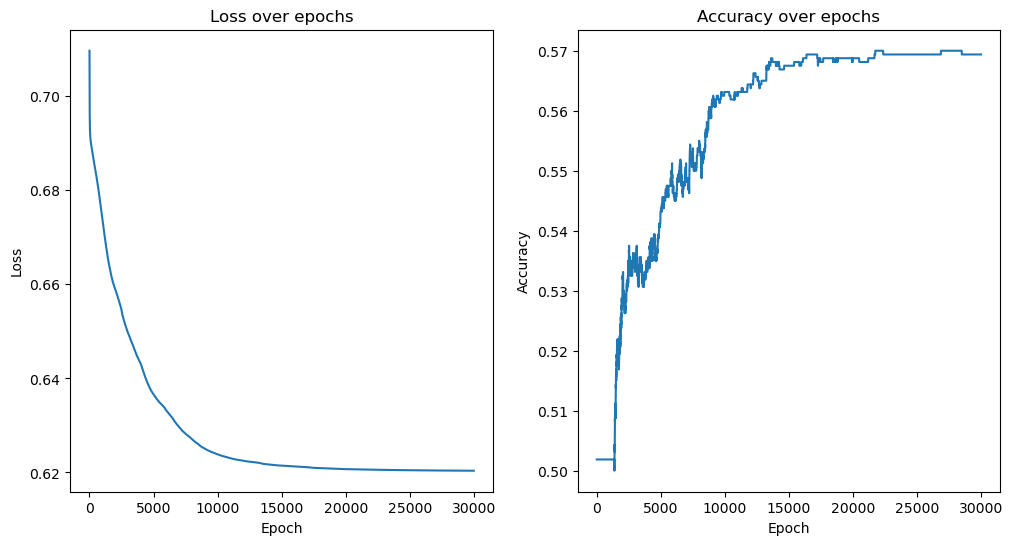

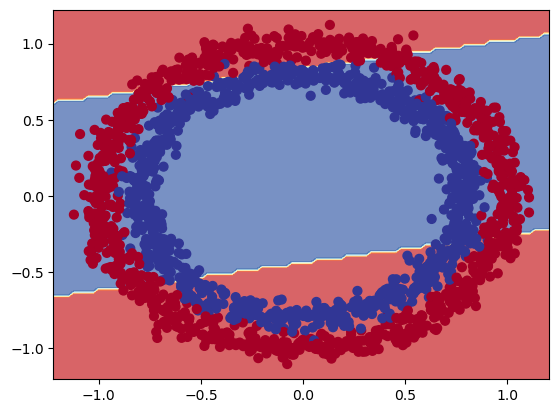

In [51]:
play_around(nn.Sequential(OrderedDict([('f1', nn.Linear(2,4)), ('f2', nn.ReLU()), ('f3', nn.Linear(4,1))])), epoch_count=30_000)

Epoch   3000: Loss = 0.6928, Accuracy = 50.1875%
Epoch   6000: Loss = 0.6916, Accuracy = 50.1875%
Epoch   9000: Loss = 0.6834, Accuracy = 50.1875%
Epoch  12000: Loss = 0.6577, Accuracy = 50.1875%
Epoch  15000: Loss = 0.5613, Accuracy = 60.1875%
Epoch  18000: Loss = 0.4670, Accuracy = 76.2500%
Epoch  21000: Loss = 0.4140, Accuracy = 80.0000%
Epoch  24000: Loss = 0.3753, Accuracy = 83.5000%
Epoch  27000: Loss = 0.3443, Accuracy = 86.1875%
Epoch  30000: Loss = 0.3178, Accuracy = 87.8750%
Min loss for 30000 epochs is 0.31778058409690857
Max acc for 30000 epochs is 87.875%


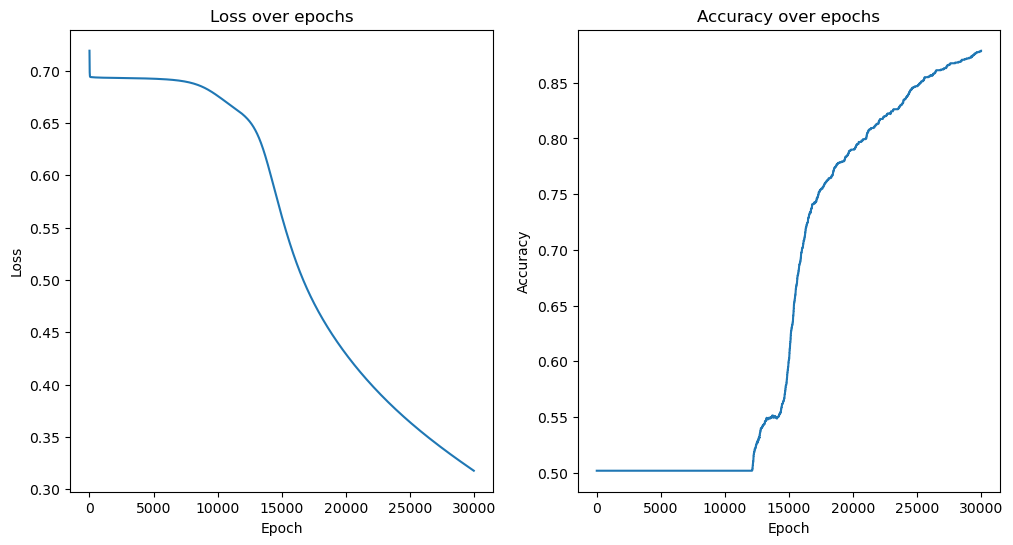

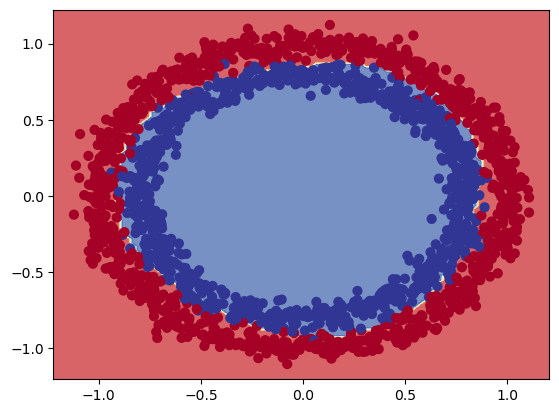

In [52]:
play_around(nn.Sequential(OrderedDict([('f1', nn.Linear(2,4)), ('f2', nn.Sigmoid()), ('f3', nn.Linear(4,1))])), epoch_count=30_000)

Epoch   3000: Loss = 0.3122, Accuracy = 91.1250%
Epoch   6000: Loss = 0.1638, Accuracy = 93.5625%
Epoch   9000: Loss = 0.1458, Accuracy = 93.8125%
Epoch  12000: Loss = 0.1409, Accuracy = 94.0000%
Epoch  15000: Loss = 0.1392, Accuracy = 94.0000%
Epoch  18000: Loss = 0.1384, Accuracy = 94.0000%
Epoch  21000: Loss = 0.1381, Accuracy = 93.9375%
Epoch  24000: Loss = 0.1379, Accuracy = 94.0000%
Epoch  27000: Loss = 0.1378, Accuracy = 94.0000%
Epoch  30000: Loss = 0.1377, Accuracy = 94.0000%
Min loss for 30000 epochs is 0.1377389281988144
Max acc for 30000 epochs is 94.0%


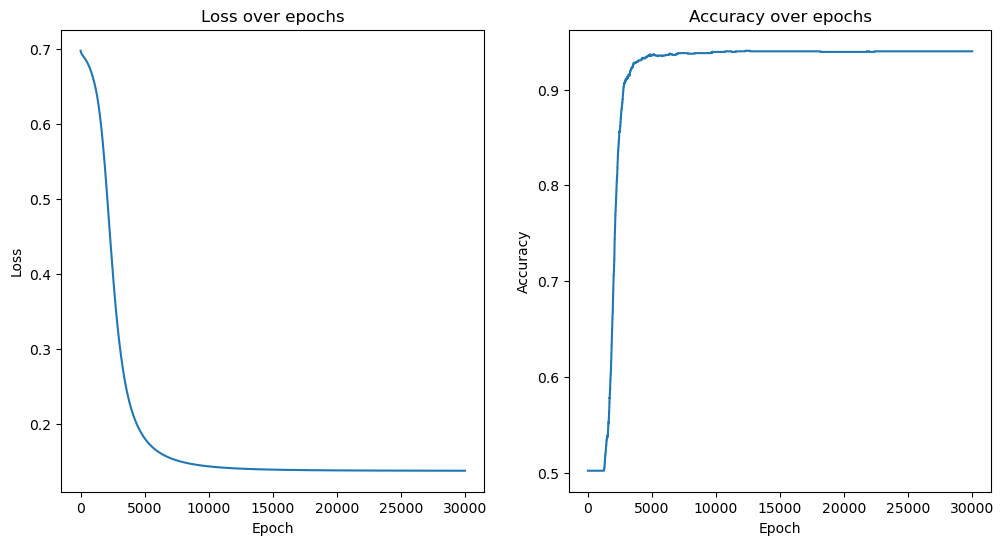

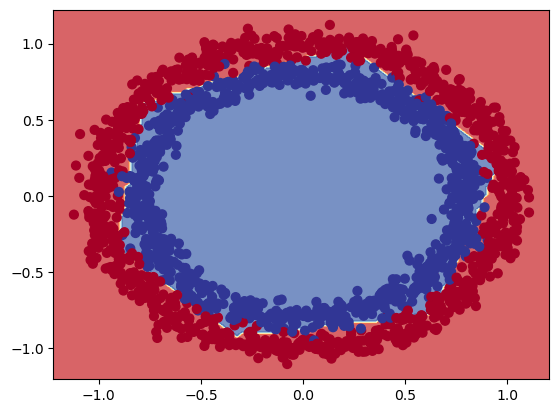

In [53]:
play_around(nn.Sequential(OrderedDict([('f1', nn.Linear(2,4)), ('f2', nn.ReLU()),('f3', nn.ReLU()) ,('f4', nn.Linear(4,1))])), epoch_count=30_000)

Epoch   3000: Loss = 0.6651, Accuracy = 50.1875%
Epoch   6000: Loss = 0.4286, Accuracy = 79.6875%
Epoch   9000: Loss = 0.3231, Accuracy = 88.2500%
Epoch  12000: Loss = 0.2677, Accuracy = 92.0625%
Epoch  15000: Loss = 0.2329, Accuracy = 93.3125%
Epoch  18000: Loss = 0.2089, Accuracy = 94.0625%
Epoch  21000: Loss = 0.1912, Accuracy = 95.0625%
Epoch  24000: Loss = 0.1775, Accuracy = 95.3125%
Epoch  27000: Loss = 0.1665, Accuracy = 95.5625%
Epoch  30000: Loss = 0.1576, Accuracy = 95.6875%
Min loss for 30000 epochs is 0.15757262706756592
Max acc for 30000 epochs is 95.6875%


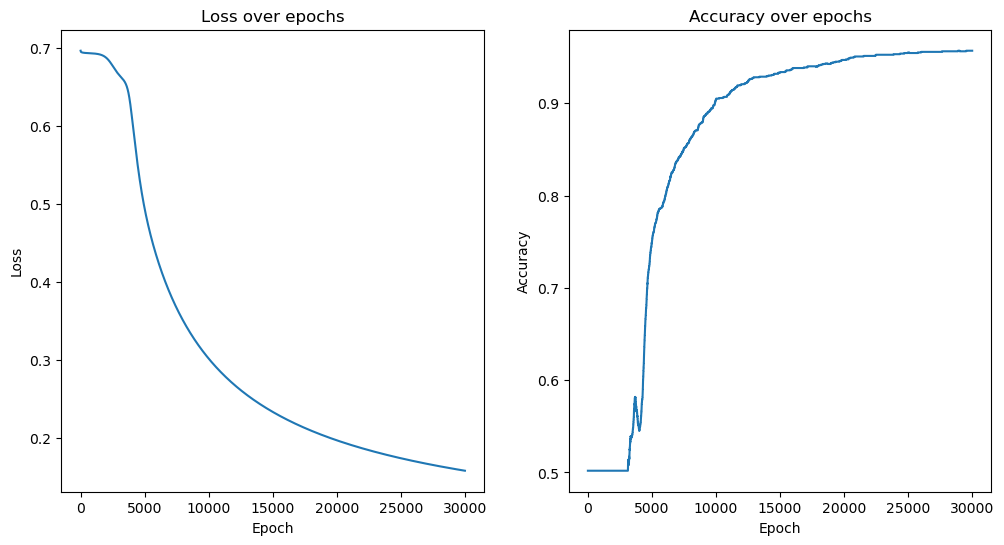

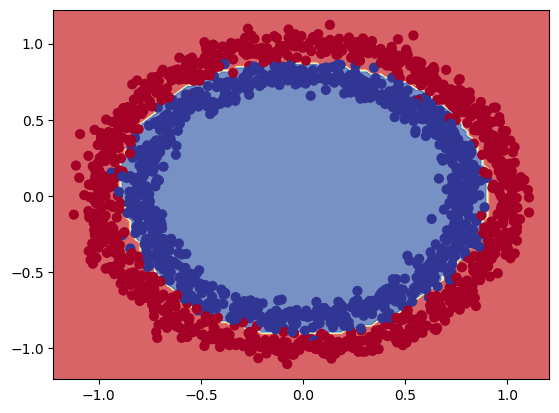

In [54]:
play_around(nn.Sequential(OrderedDict([('f1', nn.Linear(2,4)), ('f2', nn.Tanh()), ('f3', nn.Linear(4,1))])), epoch_count=30_000)

# Multiclass classification
We will create a dataset using make blobs method. The centers are the number of classes we are targeting in this case 4. In our final model the number of clusters is the number of output features for our final layer nn.Linear(in_features=hidden_units, out_features=4)

In [38]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


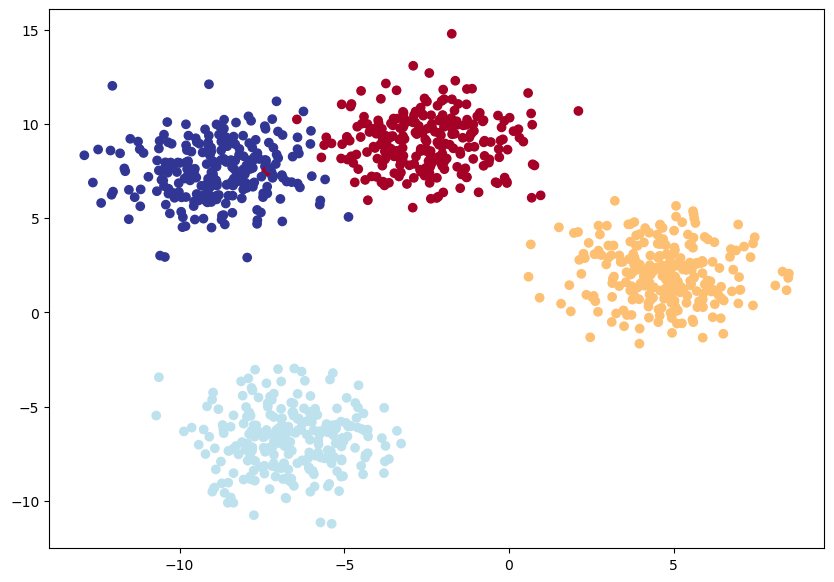

In [39]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [40]:
class MultiClassModel(nn.Module):
    def __init__(self, function: nn.Sequential, optimizer_constructor, loss_fn):  
        super(MultiClassModel, self).__init__()      
        self.function = function
        self.optimizer = optimizer_constructor(self.parameters(), lr=0.1)
        self.loss_fn = loss_fn
        
    def forward(self, X: torch.tensor) -> torch.tensor:
        return self.function(X)
    
    def run(self, inputs: torch.tensor, labels:torch.tensor, epoch_count: int=1_000) -> Tuple[List[float], List[float]]:
        loss_values = []
        acc_values = []
        for epoch in range(epoch_count):
            self.optimizer.zero_grad()
            
            outputs = self(inputs.float())
            loss = self.loss_fn(outputs, labels.long())  # Changed to labels.long() for CrossEntropyLoss

            loss.backward()
            self.optimizer.step()
            
            _, predicted_labels = torch.max(outputs, 1)
            correct = (predicted_labels == labels).sum().item()
            total = labels.size(0)
            accuracy = correct / total

            loss_values.append(loss.item())
            acc_values.append(accuracy)
            if (epoch + 1) % (epoch_count / 10) == 0:
                print(f"Epoch {epoch + 1:6d}: Loss = {loss.item():.4f}, Accuracy = {100* accuracy:.4f}%")        
        return loss_values, acc_values


In [41]:
structure = nn.Sequential(OrderedDict([
    ('f1',nn.Linear(2, 64)),
    ('f2',nn.Linear(64, 64)),
    ('f3',nn.Linear(64, 4))]))
model = MultiClassModel(structure, torch.optim.SGD, nn.CrossEntropyLoss())
loss, acc = model.run(X_blob,y_blob)

Epoch    100: Loss = 0.0236, Accuracy = 99.3000%
Epoch    200: Loss = 0.0222, Accuracy = 99.3000%
Epoch    300: Loss = 0.0215, Accuracy = 99.4000%
Epoch    400: Loss = 0.0210, Accuracy = 99.4000%
Epoch    500: Loss = 0.0206, Accuracy = 99.4000%
Epoch    600: Loss = 0.0202, Accuracy = 99.4000%
Epoch    700: Loss = 0.0199, Accuracy = 99.4000%
Epoch    800: Loss = 0.0195, Accuracy = 99.4000%
Epoch    900: Loss = 0.0192, Accuracy = 99.4000%
Epoch   1000: Loss = 0.0189, Accuracy = 99.5000%


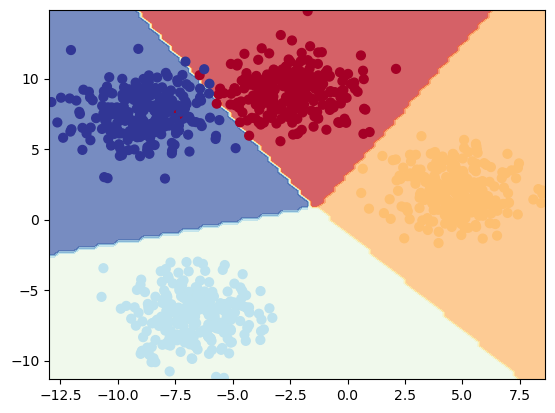

In [42]:
plot_decision_boundary(model, X_blob, y_blob)

Epoch    100: Loss = 0.0292, Accuracy = 99.2000%
Epoch    200: Loss = 0.0257, Accuracy = 99.3000%
Epoch    300: Loss = 0.0242, Accuracy = 99.3000%
Epoch    400: Loss = 0.0233, Accuracy = 99.3000%
Epoch    500: Loss = 0.0226, Accuracy = 99.3000%
Epoch    600: Loss = 0.0221, Accuracy = 99.3000%
Epoch    700: Loss = 0.0217, Accuracy = 99.3000%
Epoch    800: Loss = 0.0214, Accuracy = 99.3000%
Epoch    900: Loss = 0.0211, Accuracy = 99.3000%
Epoch   1000: Loss = 0.0208, Accuracy = 99.3000%


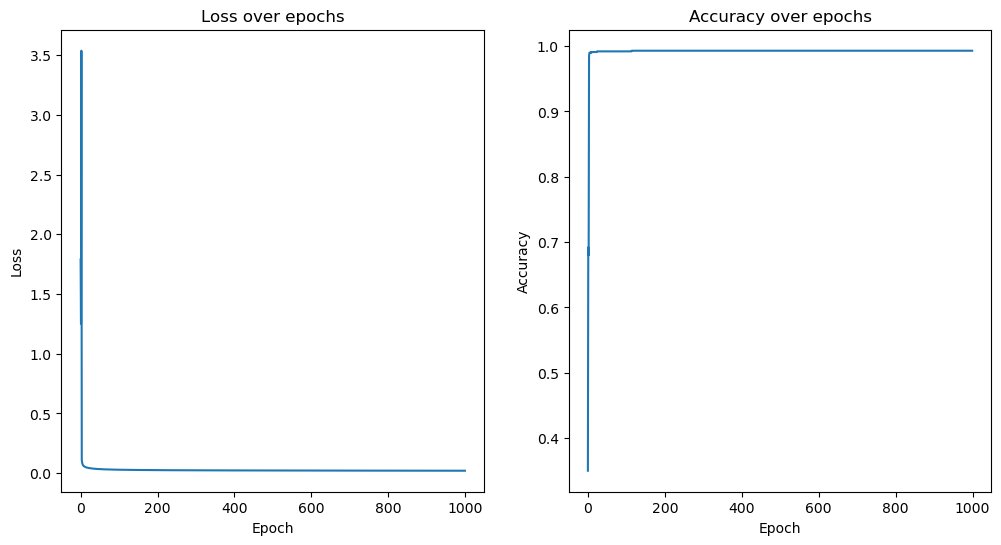

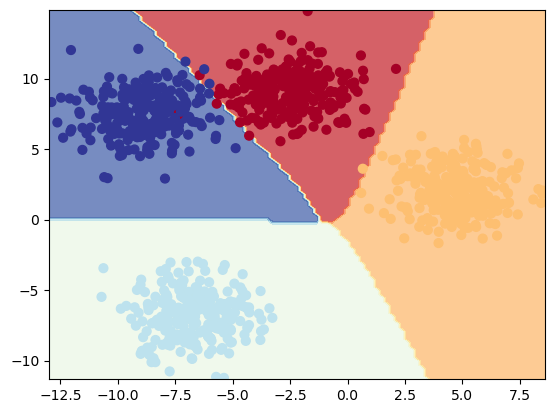

In [43]:
structure = nn.Sequential(OrderedDict([
    ('f1',nn.Linear(2, 64)),
    ('f2',nn.ReLU()),
    ('f3',nn.Linear(64, 4))]))
model = MultiClassModel(structure, torch.optim.SGD, nn.CrossEntropyLoss())
losses, accuracies = model.run(X_blob,y_blob)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.plot(losses)
    
plt.subplot(1, 2, 2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.plot(accuracies)
        
plt.show()

plot_decision_boundary(model, X_blob, y_blob)

Epoch    100: Loss = 0.0930, Accuracy = 99.2000%
Epoch    200: Loss = 0.0553, Accuracy = 99.2000%
Epoch    300: Loss = 0.0427, Accuracy = 99.2000%
Epoch    400: Loss = 0.0365, Accuracy = 99.3000%
Epoch    500: Loss = 0.0328, Accuracy = 99.3000%
Epoch    600: Loss = 0.0303, Accuracy = 99.3000%
Epoch    700: Loss = 0.0285, Accuracy = 99.3000%
Epoch    800: Loss = 0.0271, Accuracy = 99.4000%
Epoch    900: Loss = 0.0260, Accuracy = 99.4000%
Epoch   1000: Loss = 0.0251, Accuracy = 99.4000%


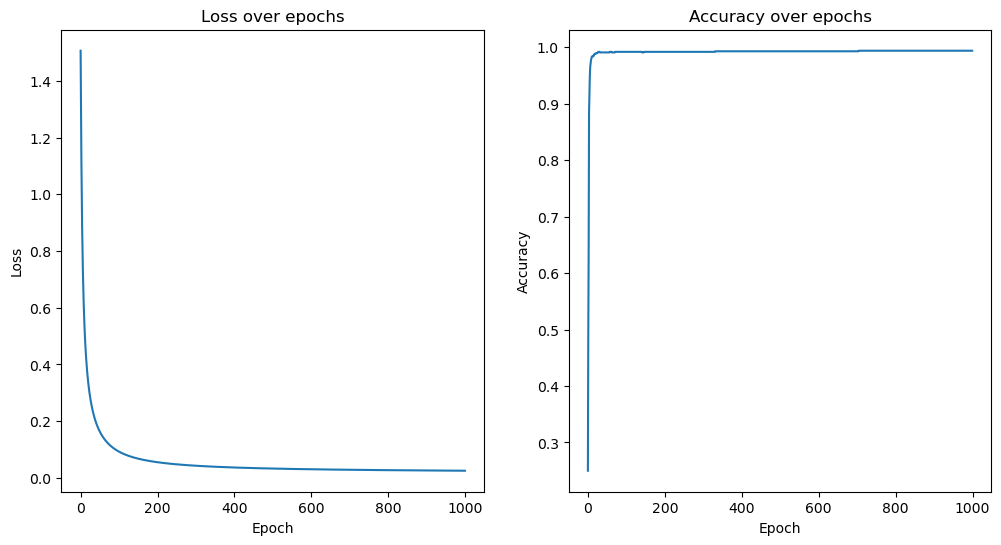

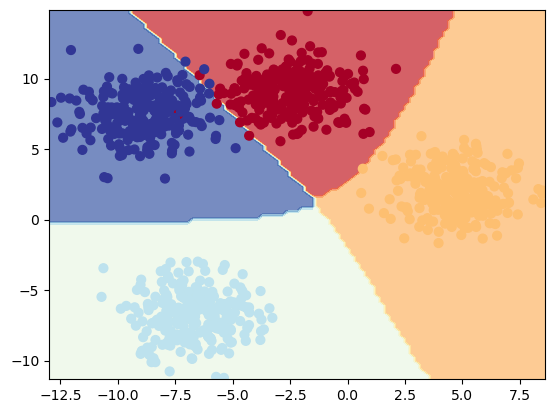

In [44]:
structure = nn.Sequential(OrderedDict([
    ('f1',nn.Linear(2, 64)),
    ('f2',nn.Sigmoid()),
    ('f3',nn.Linear(64, 4))]))
model = MultiClassModel(structure, torch.optim.SGD, nn.CrossEntropyLoss())
losses, accuracies = model.run(X_blob,y_blob)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.plot(losses)
    
plt.subplot(1, 2, 2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.plot(accuracies)
        
plt.show()

plot_decision_boundary(model, X_blob, y_blob)

Epoch    100: Loss = 0.1001, Accuracy = 99.2000%
Epoch    200: Loss = 0.0589, Accuracy = 99.2000%
Epoch    300: Loss = 0.0449, Accuracy = 99.3000%
Epoch    400: Loss = 0.0379, Accuracy = 99.3000%
Epoch    500: Loss = 0.0336, Accuracy = 99.3000%
Epoch    600: Loss = 0.0308, Accuracy = 99.3000%
Epoch    700: Loss = 0.0288, Accuracy = 99.3000%
Epoch    800: Loss = 0.0272, Accuracy = 99.3000%
Epoch    900: Loss = 0.0260, Accuracy = 99.4000%
Epoch   1000: Loss = 0.0251, Accuracy = 99.4000%


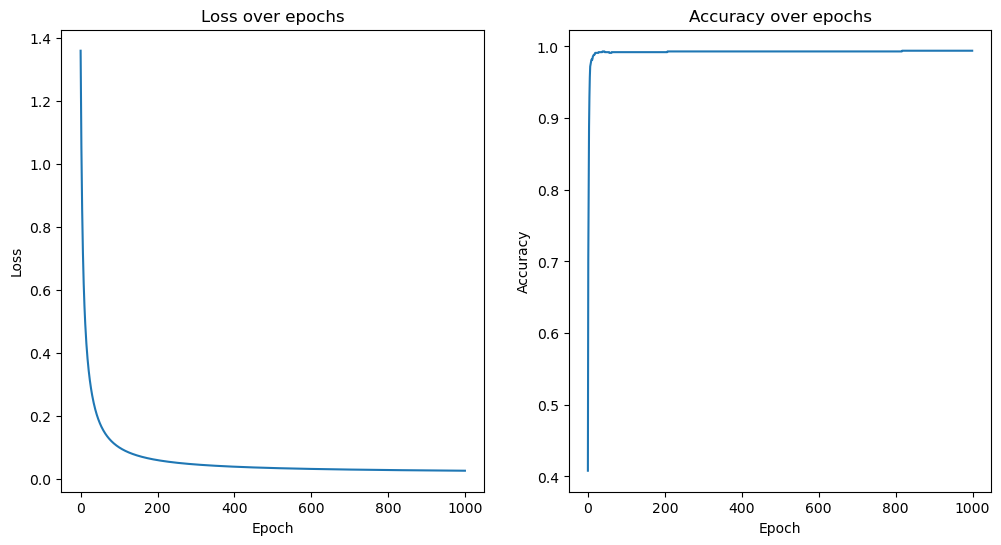

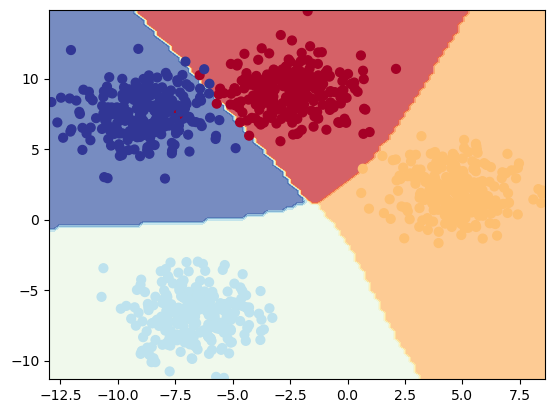

In [45]:
structure = nn.Sequential(OrderedDict([
    ('f1', nn.Linear(2, 64)),
    ('f2', nn.Sigmoid()),
    ('f3', nn.ReLU()),
    ('f3',nn.Linear(64, 4))]))
model = MultiClassModel(structure, torch.optim.SGD, nn.CrossEntropyLoss())
losses, accuracies = model.run(X_blob,y_blob)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.plot(losses)
    
plt.subplot(1, 2, 2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.plot(accuracies)
        
plt.show()

plot_decision_boundary(model, X_blob, y_blob)